In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms

transform = transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
bs = 128
#full train dataset
trainset = tv.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

#splitting train dataset into training and validation sets
trainset_size = len(trainset)
valset_size = int(0.2 * trainset_size)  # 20% for validation
trainset, valset = torch.utils.data.random_split(trainset, [trainset_size - valset_size, valset_size])

#training dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=2)

#validation dataloader
valloader = torch.utils.data.DataLoader(valset, batch_size=bs, shuffle=False, num_workers=2)

#test dataset
testset = tv.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:13<00:00, 12452940.03it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Checking if GPU is available and assigning device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#define model
class FirstCNN(nn.Module):
  def __init__(self):
    super(FirstCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv5 = nn.Conv2d(256, 512, 3, padding=1)

    self.fc1 = nn.Linear(512, 120)
    self.fc2 = nn.Linear(120, 75)
    self.fc3 = nn.Linear(75,10)

    self.mp = nn.MaxPool2d(2,2)
    self.ap = nn.AvgPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.out = nn.LogSoftmax(dim = 1)


  def forward(self, x):
    x = self.mp(F.relu(self.conv1(x)))
    x = self.mp(F.relu(self.conv2(x)))
    x = self.mp(F.relu(self.conv3(x)))
    x = self.ap(F.relu(self.conv4(x)))
    x = self.ap(F.relu(self.conv5(x)))

    x = torch.flatten(x, 1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.fc3(x)

    x = self.out(x)
    return x

net = FirstCNN().to(device)

#optimization & loss function

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.5)

Using device: cuda


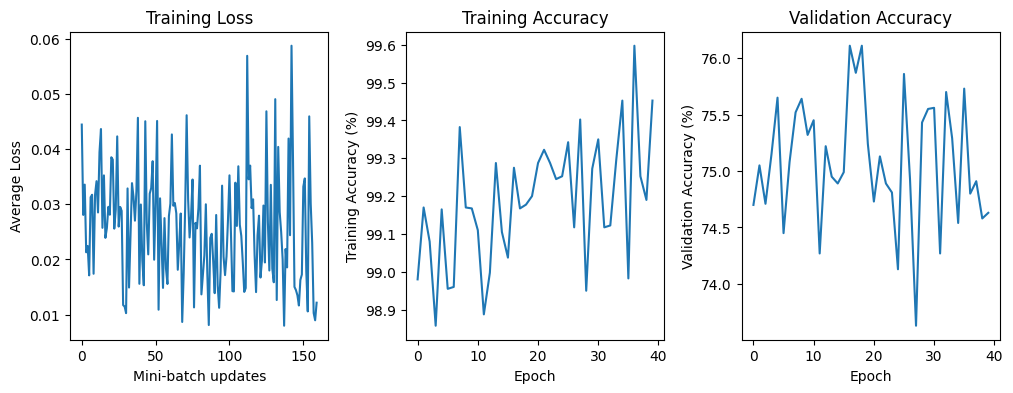

Training finished
Accuracy of the network on the 10000 test images: 74 %


In [9]:
import matplotlib.pyplot as plt
import torch

epochs = 40
losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 64 == 63:  # current mini_batch index
            losses.append(running_loss / 64)
            running_loss = 0.0

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validating the model
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

# Set figure size
plt.figure(figsize=(12, 4))
# Plot training loss
plt.subplot(131)
plt.plot(losses)
plt.xlabel('Mini-batch updates')
plt.ylabel('Average Loss')
plt.title('Training Loss')

# Plot training accuracy
plt.subplot(132)
plt.plot(train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy')

# Plot validation accuracy
plt.subplot(133)
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy')

# Add space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

print("Training finished")

#testing the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


# Save the trained model
model_path = 'trained_model.pth'
torch.save(net.state_dict(), model_path)

Predicted class: horse


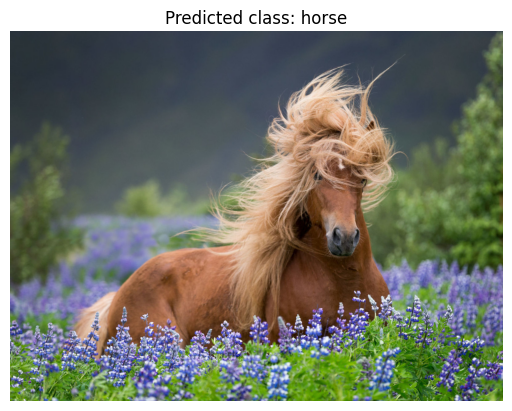

In [12]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to match the input size of your model
    transforms.ToTensor(),        # Convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Apply normalization
])

# Load the trained model
model_path = 'trained_model.pth'
loaded_model = FirstCNN()
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

# Load and preprocess the image
image_path = 'sample.jpg'
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = loaded_model(image_tensor)
    _, predicted = torch.max(output, 1)

# Get the predicted class label
predicted_class = predicted.item()

# Define the class labels of CIFAR-10 dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Print the predicted class label
print("Predicted class:", classes[predicted_class])

# Display the image
plt.imshow(image)
plt.axis('off')
plt.title('Predicted class: ' + classes[predicted_class])
plt.show()